# Popular places

#### Visualisation of popular places in Prague

In [1]:
import urllib2
import json
import api_key
import pandas as pd
import colorsys
import time

requestURL = 'https://maps.googleapis.com/maps/api/place/textsearch/json?query=places%20of%20intest%20in%20Prague&key=' + api_key.API_KEY

def parse_next(json_data, names, lats, lngs, ratings):
    parsed = 0
    for result in json_data['results']:
        if (('name' in result) and ('rating' in result) and ('geometry' in result) and ('location' in result['geometry'])
            and ('lat' in result['geometry']['location']) and ('lng' in result['geometry']['location'])):
            names.append(result['name'])
            ratings.append(result['rating'])
            lats.append(result['geometry']['location']['lat'])
            lngs.append(result['geometry']['location']['lng'])
            parsed += 1
    return parsed

names = []
lats = []
lngs = []
ratings = []
parsed = 0
to_parse = 200
next_page_token = None

places = pd.DataFrame()

while parsed < to_parse:
    new_address = requestURL
    if next_page_token is not None:
        new_address = requestURL + '&pagetoken=' + str(next_page_token)

    #print(new_address)
    html = urllib2.urlopen(new_address).read().decode('utf-8')
    data = json.loads(html)
    parsed += parse_next(data, names, lats, lngs, ratings)

    if 'next_page_token' not in data:
        break
    
    next_page_token = data['next_page_token']
    time.sleep(5)

In [3]:
def rescale_ratings(ratings):
    print "Max rating: ", max(ratings)
    print "Min rating: ", min(ratings)
    print "Avg rating: ", sum(ratings) / len(ratings)
    
    rescaled = [(x - min(ratings)) / (max(ratings) - min(ratings)) for x in ratings]
    return rescaled


In [6]:
places['name'] = names
places['lat'] = lats
places['lng'] = lngs
places['rating'] = ratings

rescaled = rescale_ratings(ratings)

colors_normal = [0] * len(names)
colors_scaled = [0] * len(names)
for i in range(len(names)):
    colors_normal[i] = colorsys.hsv_to_rgb(ratings[i] / 5.0 / 3.6, 1, 1)
    colors_scaled[i] = colorsys.hsv_to_rgb(rescaled[i] / 3.6, 1, 1)
    
print "Total: ", len(places)
places[:15]

Max rating:  5
Min rating:  3.5
Avg rating:  4.37592592593
Total:  54


name        lat        lng  \
0   National Memorial to the Heroes of the Heydric...  50.075950  14.416980   
1                                 St. Vitus Cathedral  50.090892  14.400511   
2                                     Old Town Square  50.087569  14.421187   
3                                            Vyšehrad  50.064416  14.420024   
4          Sightseeing Prague Tours Bus Boat & Castle  50.084833  14.421440   
5                                     Municipal House  50.087721  14.427791   
6                                       Dancing House  50.075403  14.414179   
7                                         Lennon Wall  50.086251  14.406792   
8                           Taste of Prague Food Tour  50.088804  14.433509   
9                                 Prague Segway Tours  50.086206  14.405037   
10                           Segway Experience Prague  50.087350  14.406008   
11                                         Prague Zoo  50.117846  14.405875   
12                                   The Powder Tower  50.087273  14.427789   
13                             Jewish Ceremonial Hall  50.090035  14.417041   
14                                        Clementinum  50.086598  14.416019   

    rating  
0      4.8  
1      4.7  
2      4.6  
3      4.6  
4      4.1  
5      4.3  
6      4.1  
7      4.0  
8      5.0  
9      4.9  
10     4.3  
11     4.7  
12     4.6  
13     4.5  
14     4.3

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimg
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import colorsys

MIN_LNG = 14.38
MAX_LNG = 14.45
MIN_LAT = 50.07
MAX_LAT = 50.11

ZOOM_LEVEL = 14
POINT_ALPHA = 1.0
GAUSS_ALPHA = 0.4
SIZE = 80

def make_map(figsize=(16, 12), projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

def show_map(data, colors):
    
    extent = [MIN_LNG, MAX_LNG, MIN_LAT, MAX_LAT]
    
    request = cimg.OSM()
    fig, ax = make_map(figsize=(16,12), projection=request.crs)
    ax.set_extent(extent)

    ax.add_image(request, ZOOM_LEVEL)
    ax.scatter(data['lng'], data['lat'], transform=ccrs.PlateCarree(), alpha=POINT_ALPHA, s=SIZE, c=colors)
    plt.show()

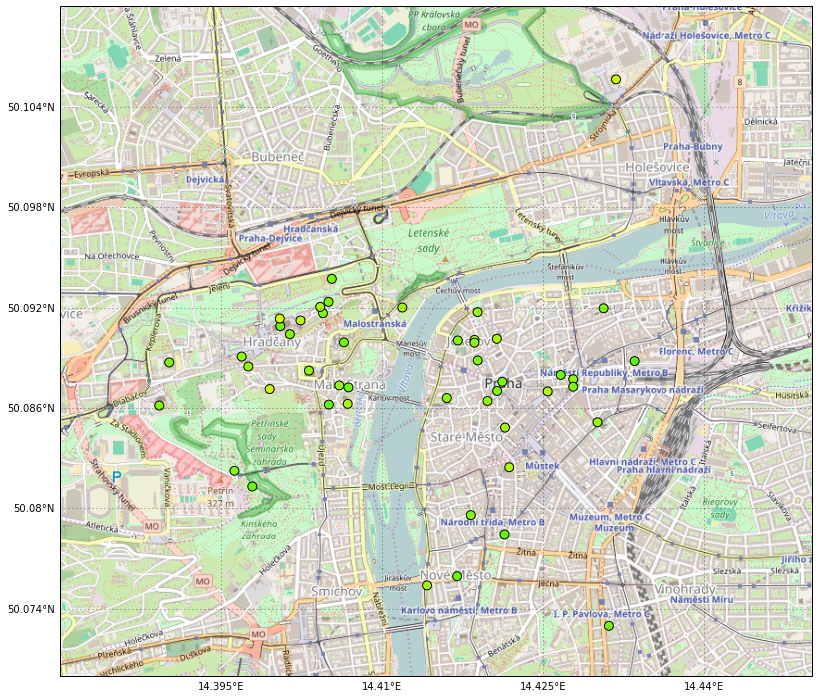

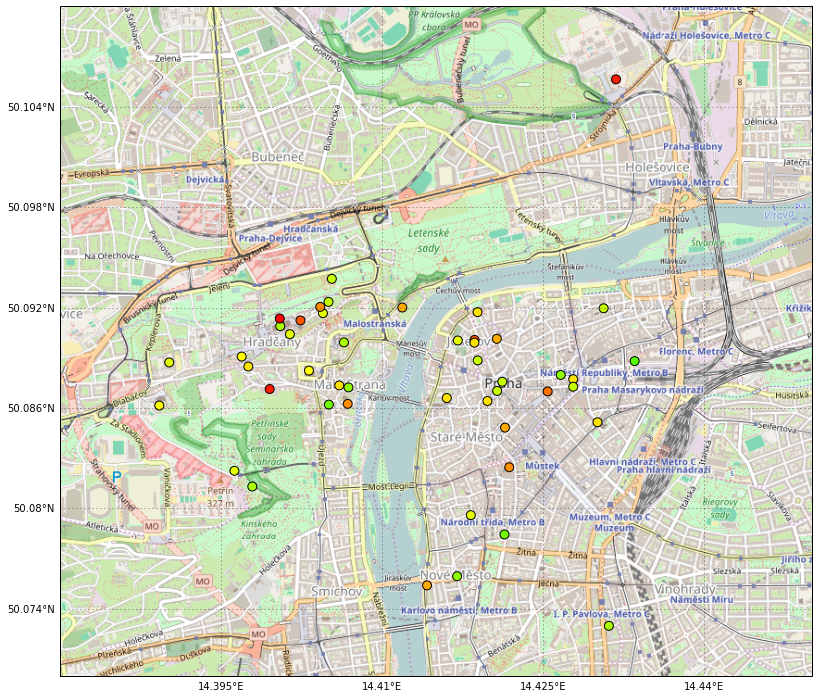

In [8]:
show_map(places, colors_normal)
show_map(places, colors_scaled)

In [14]:
from sklearn import mixture
import numpy as np

def show_gaussian(data, point_colors, components):
    # filtration
    filt = data[data.lng.between(MIN_LNG,MAX_LNG) & data.lat.between(MIN_LAT, MAX_LAT)] 

    X_train = np.array(list(zip(filt['lng'], filt['lat'])))
    clf = mixture.GMM(n_components=components, covariance_type='full', min_covar=0.0000001)
    clf.fit(X_train)

    # show results
    x = np.linspace(MIN_LNG, MAX_LNG)
    y = np.linspace(MIN_LAT, MAX_LAT)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T 
    Z = clf.score_samples(XX)[0]
    Z = Z.reshape(X.shape)

    extent = [MIN_LNG, MAX_LNG, MIN_LAT, MAX_LAT]
    
    request = cimg.OSM() 
    fig, ax = make_map(figsize=(16,12), projection=request.crs)
    ax.set_extent(extent)

    ax.add_image(request, ZOOM_LEVEL)
    ax.scatter(data['lng'], data['lat'], transform=ccrs.PlateCarree(), alpha=POINT_ALPHA, s=SIZE, c=point_colors)
    ax.contourf(X, Y, Z, transform=ccrs.PlateCarree(), levels=np.linspace(np.min(Z), np.max(Z)), alpha=GAUSS_ALPHA)

    plt.show()

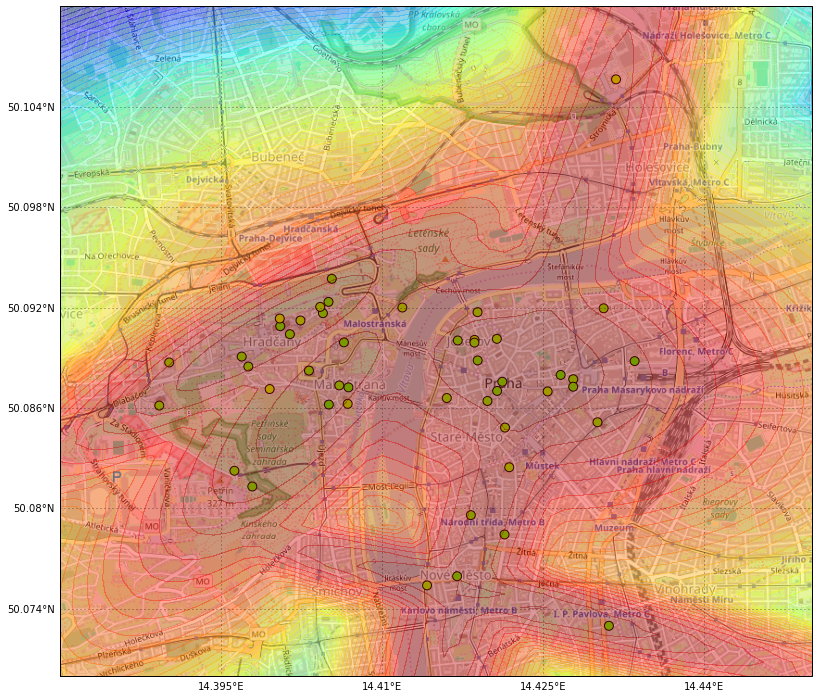

In [15]:
show_gaussian(places, colors_normal, 5)

In [79]:
places_multi = places.copy()
colors_multi = colors_scaled
rr = rescale_ratings(ratings)
for i in range(len(places)):
    value = rr[i]
    count = 0
    if (0.2 <= value < 0.4):
        count += 1
    if (0.4 <= value < 0.6):
        count += 2
    if (0.6 <= value < 0.8):
        count += 3
    if (0.8 <= value < 1.0):
        count += 4
        
        
    # TODO: multiplicate specific rows

Max rating:  5
Min rating:  3.5
Avg rating:  4.37592592593


In [78]:
#show_gaussian(places_multi, colors_multi, 5)